In [29]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans

In [31]:
def chromacity(frame):
    frame = frame.astype(np.float32)
    frame = frame / 255.
    frame_channels = cv.split(frame)
    gray = frame_channels[0] + frame_channels[1] + frame_channels[2] + 10**(-6)
    r = frame_channels[2] / gray
    g = frame_channels[1] / gray
    b = frame_channels[0] / gray
    return r, g

In [33]:
def red_cluster(frame, prev_red_cluster = None, k = 3):
    r, g = chromacity(frame)
    data = np.column_stack((r.ravel(), g.ravel())).astype(np.float32)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.02)
    _, labels, centers = cv.kmeans(data, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    centers = centers.reshape(-1, 2)
    labels_image = labels.reshape(frame.shape[:2])

    expected_red = np.array([0.6, 0.3], dtype=np.float32)
    distances = np.linalg.norm(x = (centers-expected_red), axis = 1)
    red_idx = np.argmin(distances)

    if prev_red_cluster is not None:
        distances = np.linalg.norm(x = (centers-prev_red_cluster), axis = 1)
        red_idx = np.argmin(distances)

    red_mask = (labels_image == red_idx).astype(np.uint8) * 255
    
    #kernel = cv.getStructuringElement(cv.MORPH_RECT, (15,15))
    #red_mask = cv.morphologyEx(red_mask, cv.MORPH_CLOSE, kernel)
    return red_mask, centers[red_idx]

In [35]:
def countours(bin_img, prev_cXcY = None):
    M = []
    areas = []
    cXs = []
    cYs = []
    contour = []

    contours, hierarchy = cv.findContours(bin_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for c in contours:
        area = cv.contourArea(c)
        if (area > 600) & (area < 10000):
            contour.append(c)
            m = cv.moments(c)
            M.append(m)
            
            areas.append(area)
            
            cX = int(m['m10']/m['m00'])
            cXs.append(cX)
            
            cY = int(m['m01']/m['m00'])
            cYs.append(cY)


    if len(cXs) > 1:
        if prev_cXcY is not None:
            distances = []
            for i in range(len(cXs)):
                center = np.array([cXs[i], cYs[i]])
                distance = np.linalg.norm(x = (center - prev_cXcY))
                distances.append(distance)

            distance = min(distances)
            j = distances.index(distance)
            rect = cv.minAreaRect(contour[j])
            width = int(rect[1][0])
            height = int(rect[1][1])
            angle = int(rect[2])
            if width < height:
                angle = 90 - angle
            else:
                angle = -angle
            return (cXs[j], cYs[j]), angle
        else:
            for i in range(len(cXs)-1):
                prevcenter = np.array([cXs[i], cYs[i]])
                actualcenter = np.array([cXs[i+1], cYs[i+1]])
                distance = np.linalg.norm(x = (prevcenter - actualcenter))
                if distance < 60:
                    cX = int((cXs[i]+cXs[i+1])/2)
                    cY = int((cYs[i]+cYs[i+1])/2)
                    
                    rect = cv.minAreaRect(contour[i])
                    width = int(rect[1][0])
                    height = int(rect[1][1])
                    angle = int(rect[2])
                    if width < height:
                        angle = 90 - angle
                    else:
                        angle = -angle
                    return (cX, cY), angle

    elif len(cXs) == 1:
        rect = cv.minAreaRect(contour[0])
        width = int(rect[1][0])
        height = int(rect[1][1])
        angle = int(rect[2])
        if width < height:
            angle = 90 - angle
        else:
            angle = -angle
        return (cXs[0], cYs[0]), angle

    return None, None

In [37]:
def caixa(video):
    video = cv.VideoCapture(video)
    prev_red_cluster = None
    prev_cXcY = None

    xs = []
    ys = []
    angles = []
    
    while video.isOpened():
        ret, frame = video.read()
    
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        bin_img, prev_red_cluster = red_cluster(frame = frame, prev_red_cluster = prev_red_cluster, k = 3)
        coords, angle = countours(bin_img = bin_img, prev_cXcY = prev_cXcY)
        if coords is not None:
            cX, cY = coords
            xs.append(cX)
            ys.append(cY)
            angles.append(angle)
            prev_cXcY = np.array([cX, cY])
            cv.circle(img = bin_img, center = (cX, cY), radius = 5, color = (128, 128, 128), thickness = -1)
        elif prev_cXcY is not None:
            cX, cY = prev_cXcY
            xs.append(cX)
            ys.append(cY)
            angles.append(angle)
            cv.circle(img = bin_img, center = (cX, cY), radius = 5, color = (128, 128, 128), thickness = -1)

        
        cv.imshow('frame', bin_img)
        if cv.waitKey(1) == ord('q'):
            break

    video.release()
    cv.destroyAllWindows()
    return xs, ys, angles

In [39]:
xs, ys, angles = caixa("Video1_husky.mp4")

Can't receive frame (stream end?). Exiting ...


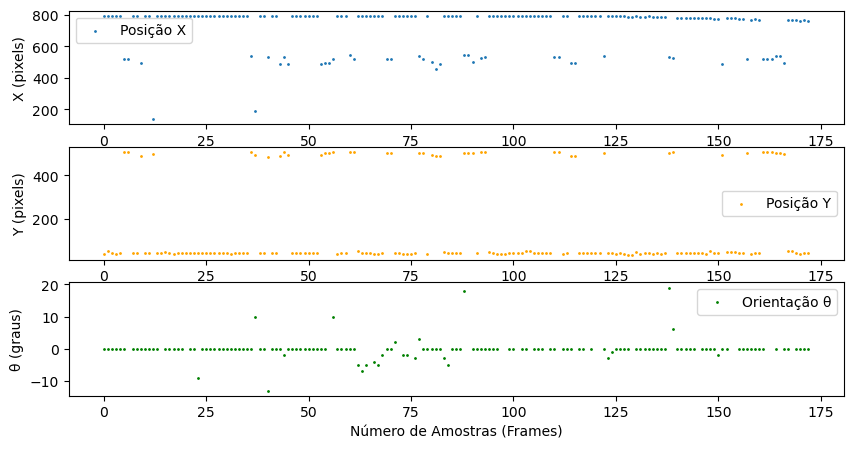

In [26]:
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.scatter(range(len(xs)), xs, label='Posição X', s = 1)
plt.ylabel('X (pixels)')
plt.legend()

plt.subplot(3,1,2)
plt.scatter(range(len(ys)), ys, label='Posição Y', color='orange', s = 1)
plt.ylabel('Y (pixels)')
plt.legend()

plt.subplot(3,1,3)
plt.scatter(range(len(angles)), angles, label='Orientação θ', color='green', s = 1)
plt.xlabel('Número de Amostras (Frames)')
plt.ylabel('θ (graus)')
plt.legend()

plt.show()

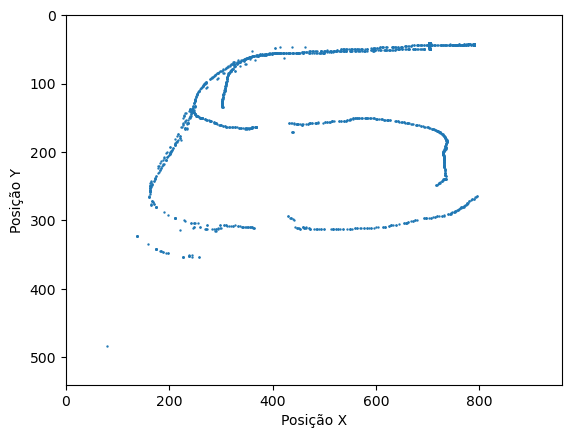

In [17]:
plt.scatter(xs, ys, s = .5)
plt.axis([0, 960, 540, 0])
plt.xlabel("Posição X")
plt.ylabel("Posição Y")
plt.show()

In [47]:
for i in range(len(xs)):
    if xs[i] < 100 and ys[i] > 400:
        xout, yout = xs[i], ys[i]
        break

In [49]:
xout, yout, i

(80, 484, 1290)